### Rerank 

It will sort the search results from best to worst based on relevance they have w.r.t query 

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
import cohere
co = cohere.Client(os.environ['COHERE_API_KEY'])
import weaviate
auth_config = weaviate.auth.AuthApiKey(
    api_key=os.environ['WEAVIATE_API_KEY'])
client = weaviate.Client(
    url=os.environ['WEAVIATE_API_URL'],
    auth_client_secret=auth_config,
    additional_headers={
        "X-Cohere-Api-Key": os.environ['COHERE_API_KEY'],
    }
)

### Dense Retrieval

In [7]:
def dense_retrieval(query, 
                    results_lang='en', 
                    properties = ["text", "title", "url", "views", "lang", "_additional {distance}"],
                    num_results=5):

    nearText = {"concepts": [query]}
    
    # To filter by language
    where_filter = {
    "path": ["lang"],
    "operator": "Equal",
    "valueString": results_lang
    }
    response = (
        client.query
        .get("Articles", properties)
        .with_near_text(nearText)
        .with_where(where_filter)
        .with_limit(num_results)
        .do()
    )

    result = response['data']['Get']['Articles']

    return result

def print_result(result):
    """ Print results with colorful formatting """
    for i,item in enumerate(result):
        print(f'item {i}')
        for key in item.keys():
            print(f"{key}:{item.get(key)}")
            print()
        print()

In [ ]:
query = "What is the capital of Canada?"
dense_retrieval_results = dense_retrieval(query, client)
print_result(dense_retrieval_results)

If you check answer of above .It has multiple results which are either correct or incorrect answers.

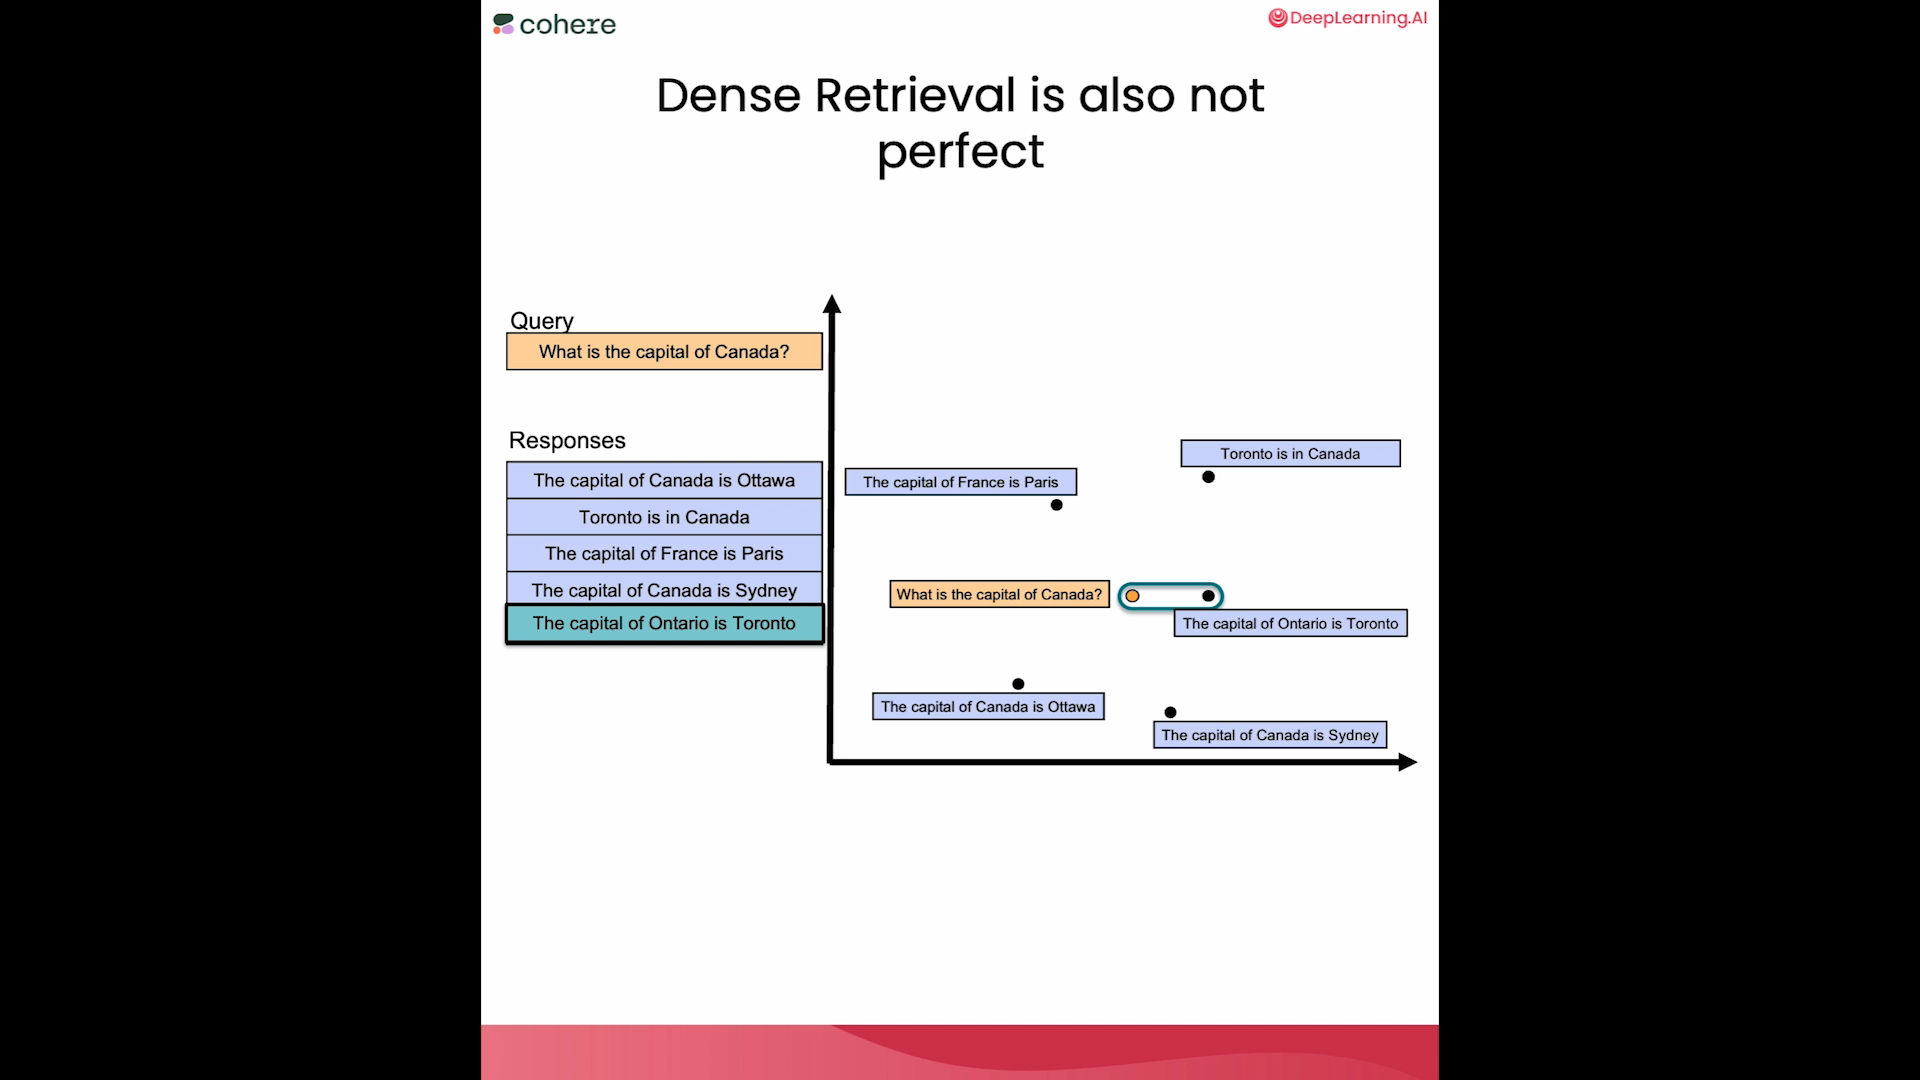

How we will fix this . This is where Rerank comes into this place.

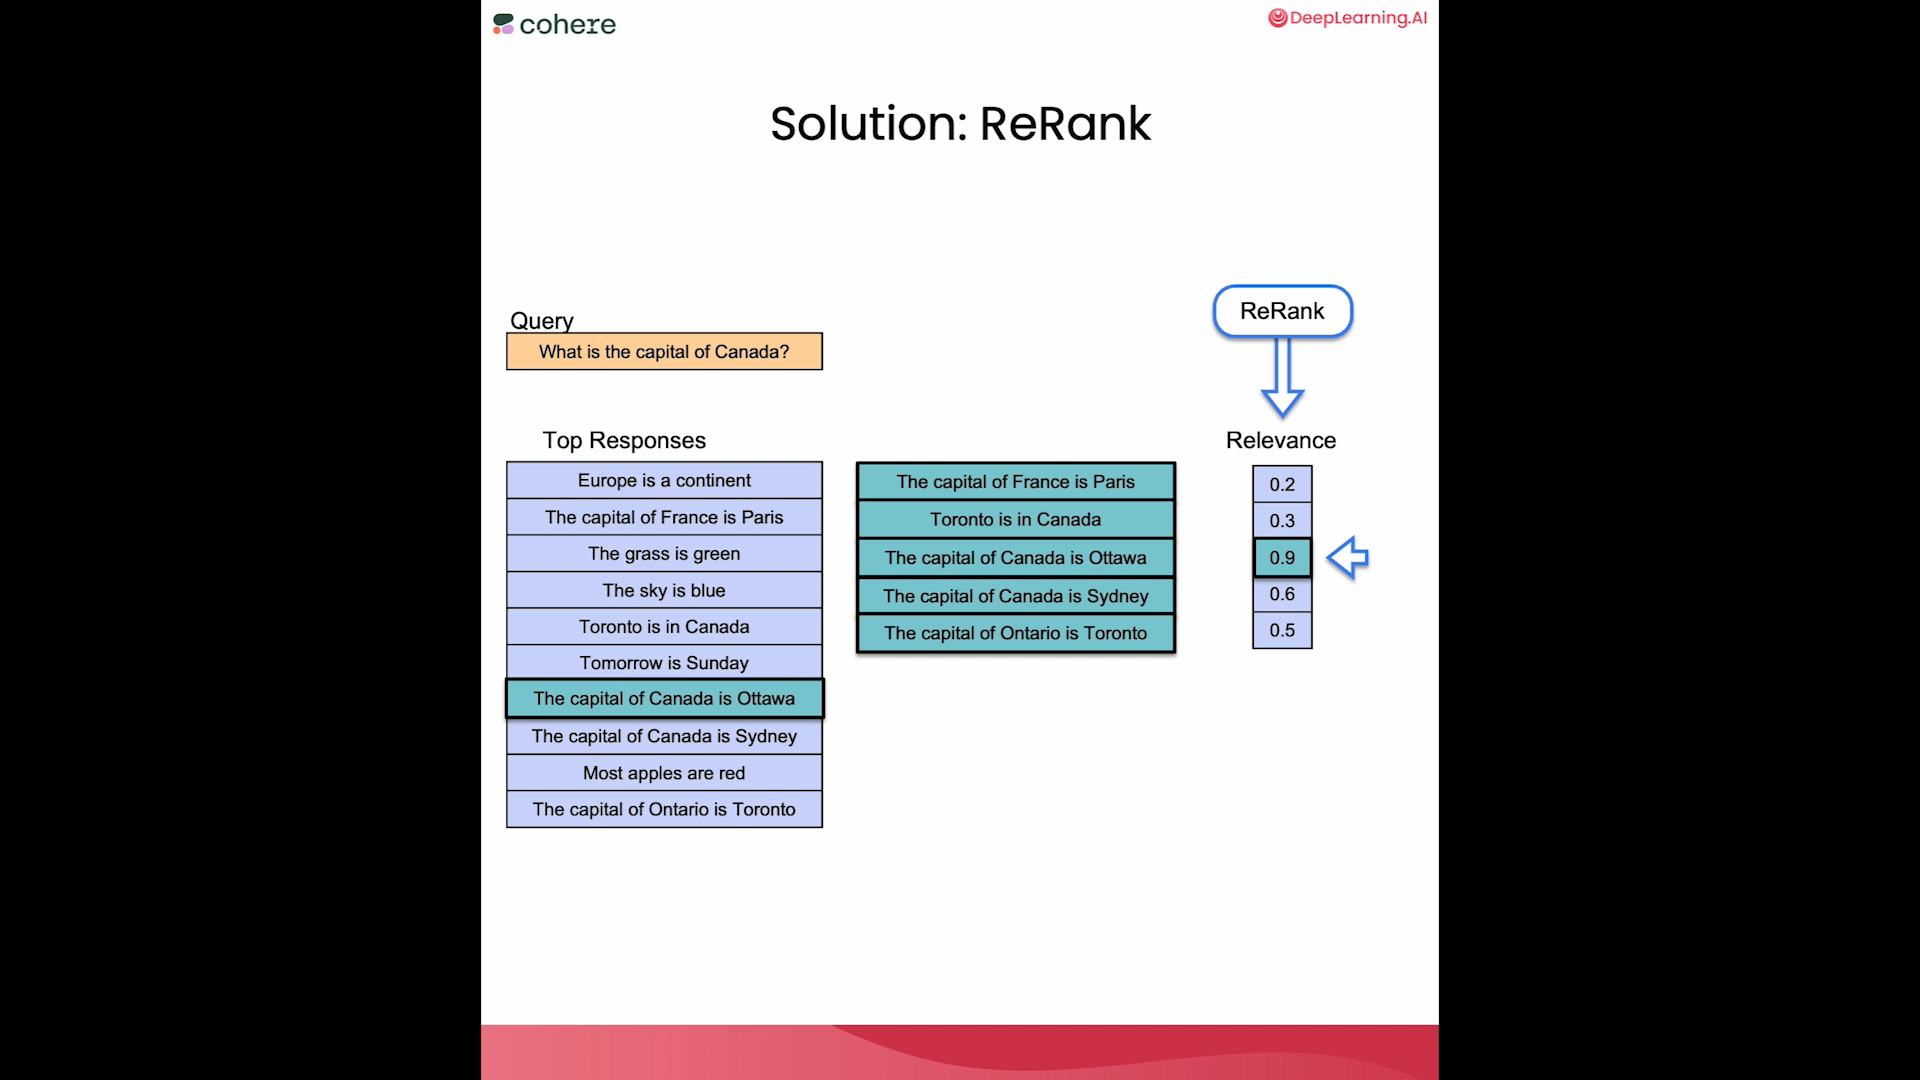

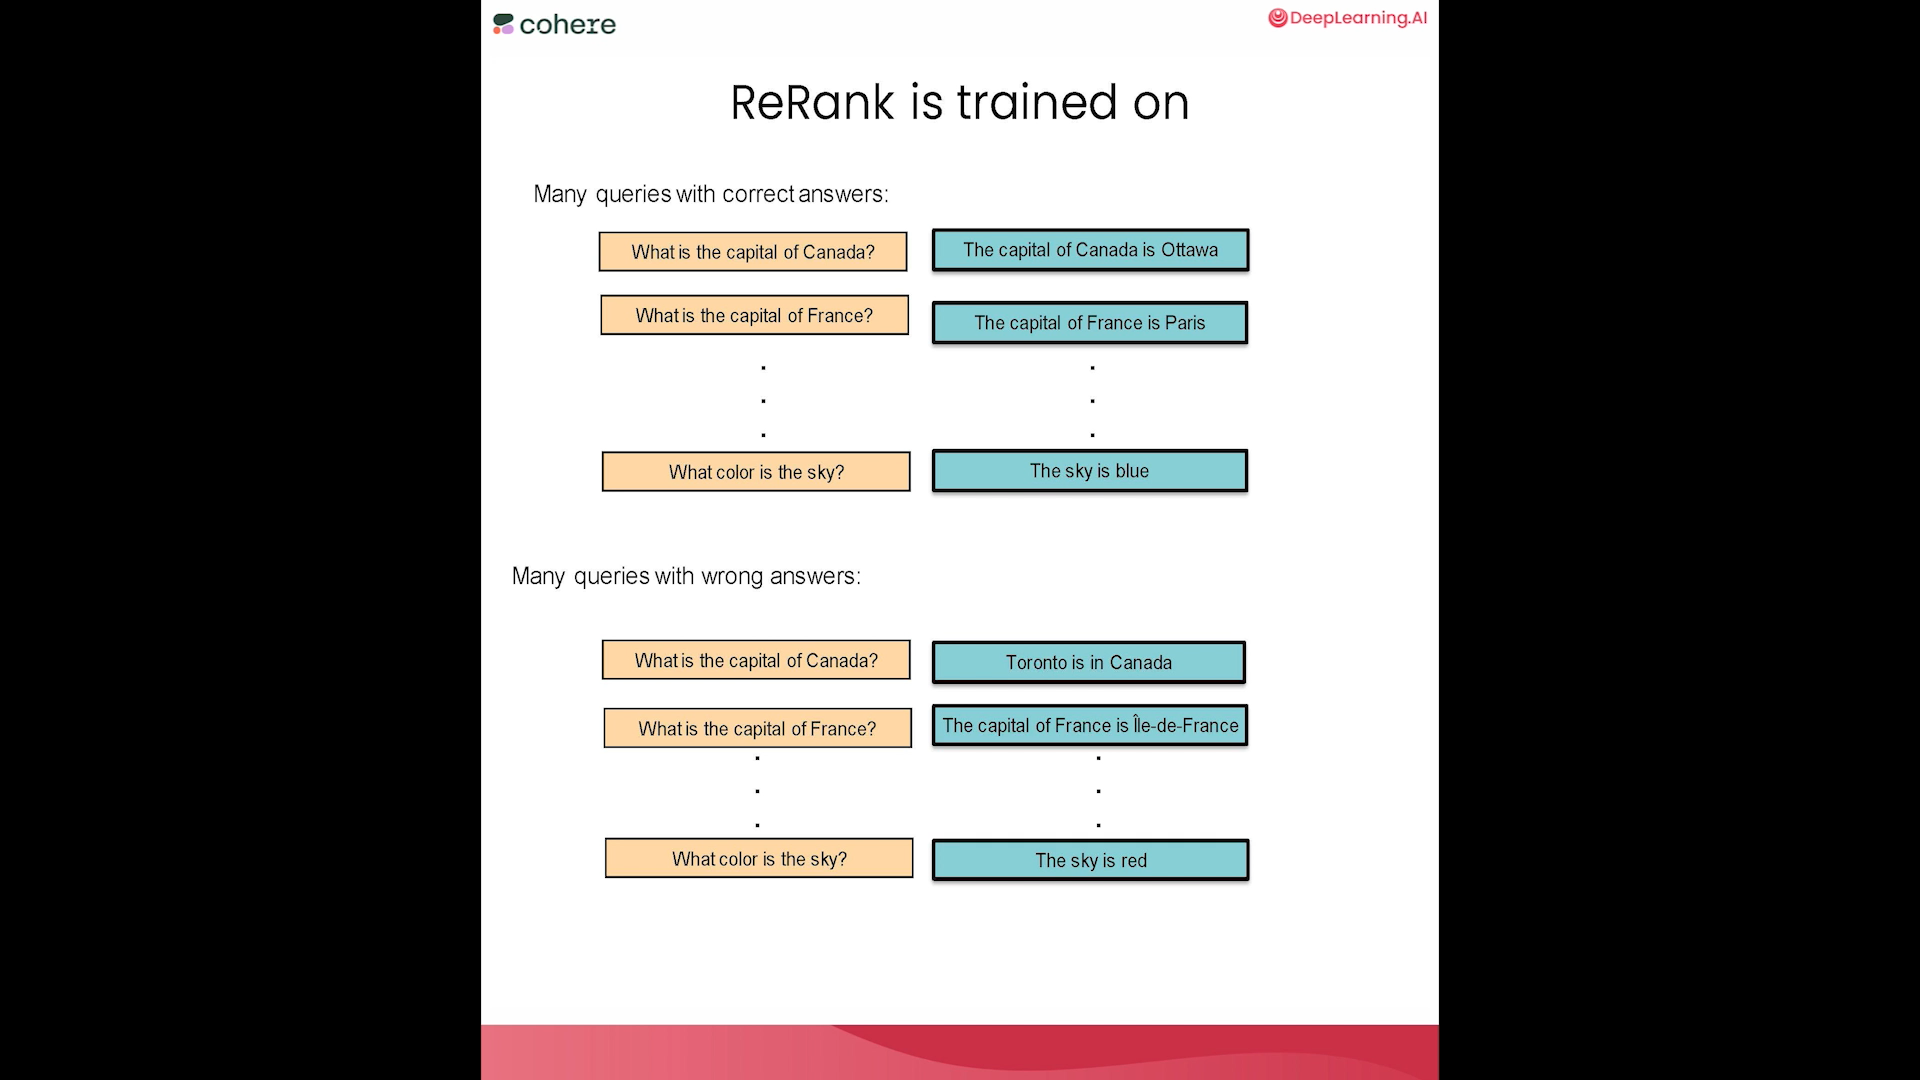

### Improving Keyword Search with ReRank

In [11]:
def keyword_search(query,
                   results_lang='en',
                   properties = ["title","url","text"],
                   num_results=3):

    where_filter = {
    "path": ["lang"],
    "operator": "Equal",
    "valueString": results_lang
    }
    
    response = (
        client.query.get("Articles", properties)
        ## bm25 is keyword search or lexical search algorithm in weaviate
        .with_bm25(
            query=query
        )
        .with_where(where_filter)
        .with_limit(num_results)
        .do()
        )

    result = response['data']['Get']['Articles']
    return result

In [ ]:

query_1 = "What is the capital of Canada?"
results = keyword_search(query_1,
                         client,
                         properties=["text", "title", "url", "views", "lang", "_additional {distance}"],
                         num_results=3
                        )

for i, result in enumerate(results):
    print(f"i:{i}")
    print(result.get('title'))
    print(result.get('text'))

Answers are not correct at all.

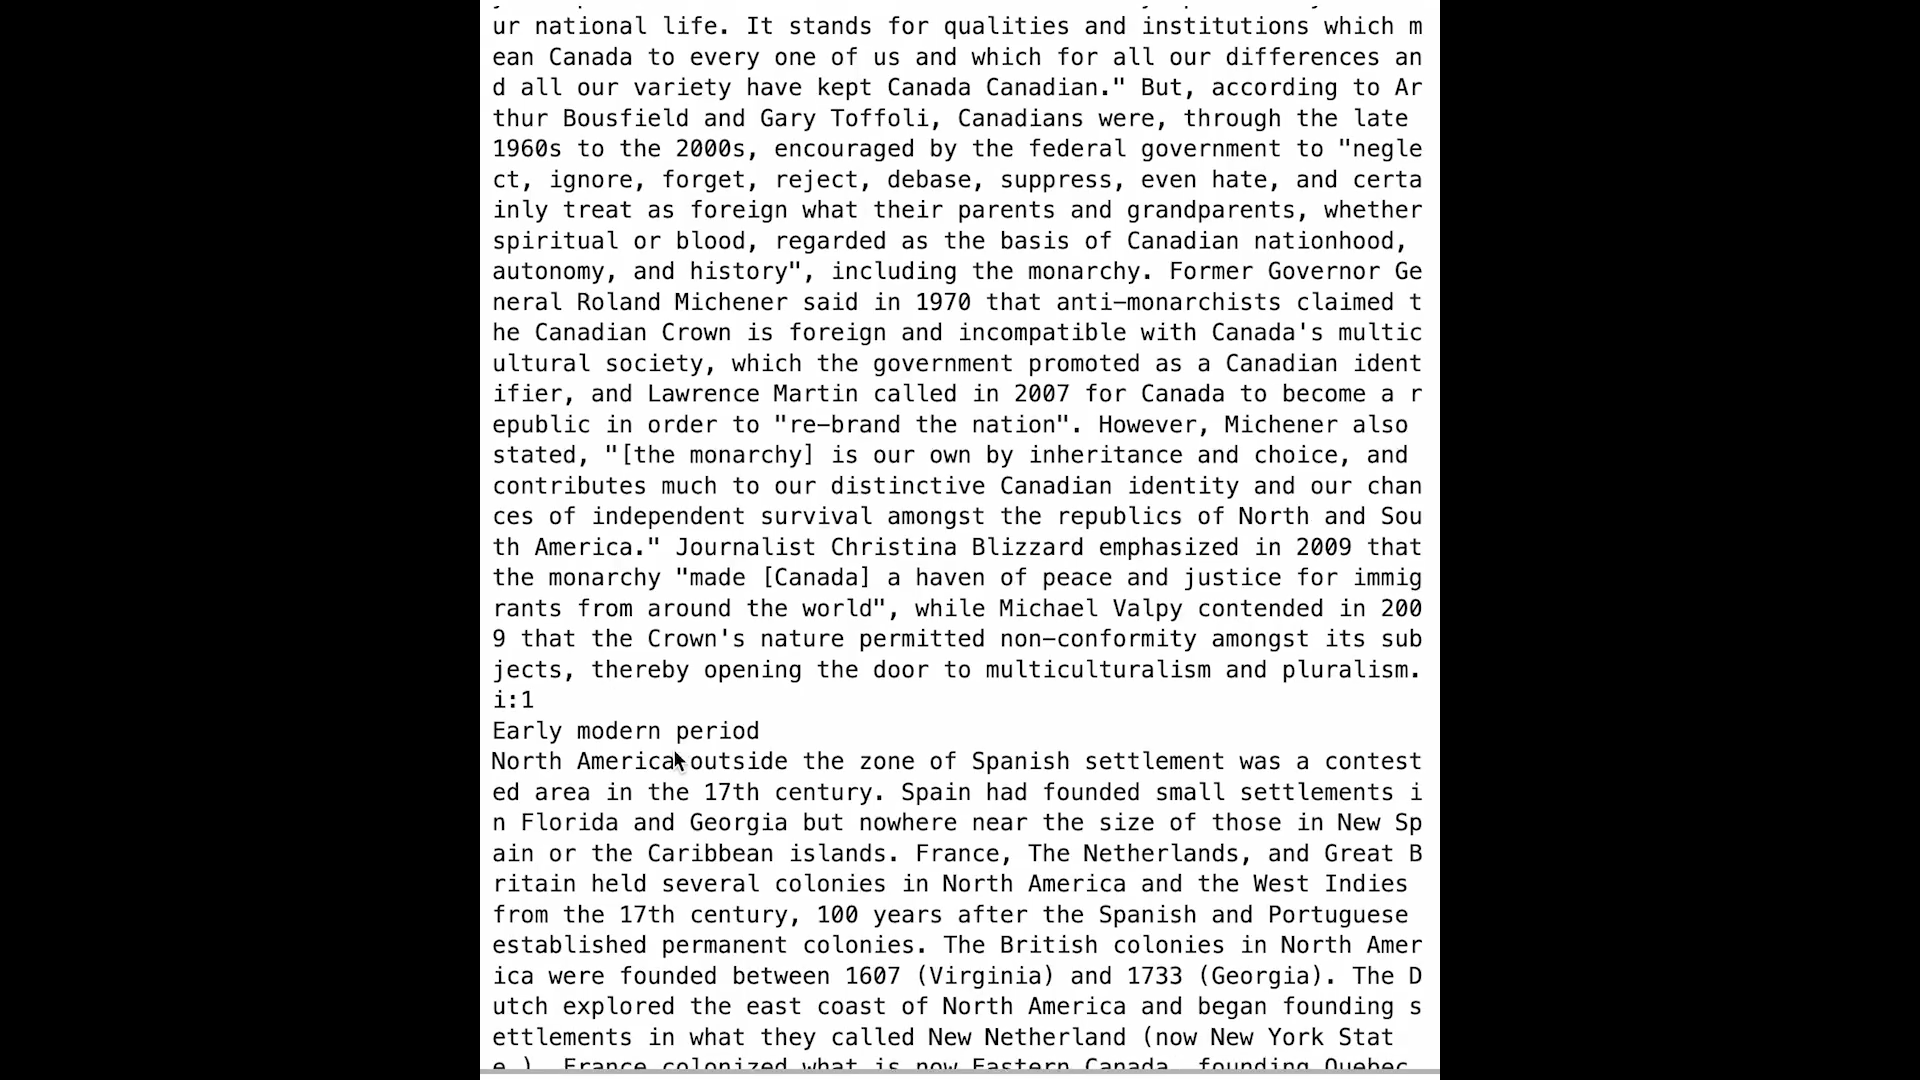

In [ ]:
query_1 = "What is the capital of Canada?"
results = keyword_search(query_1,
                         client,
                         properties=["text", "title", "url", "views", "lang", "_additional {distance}"],
                         num_results=500
                        )

for i, result in enumerate(results):
    print(f"i:{i}")
    print(result.get('title'))
    #print(result.get('text'))

500 top results with only title

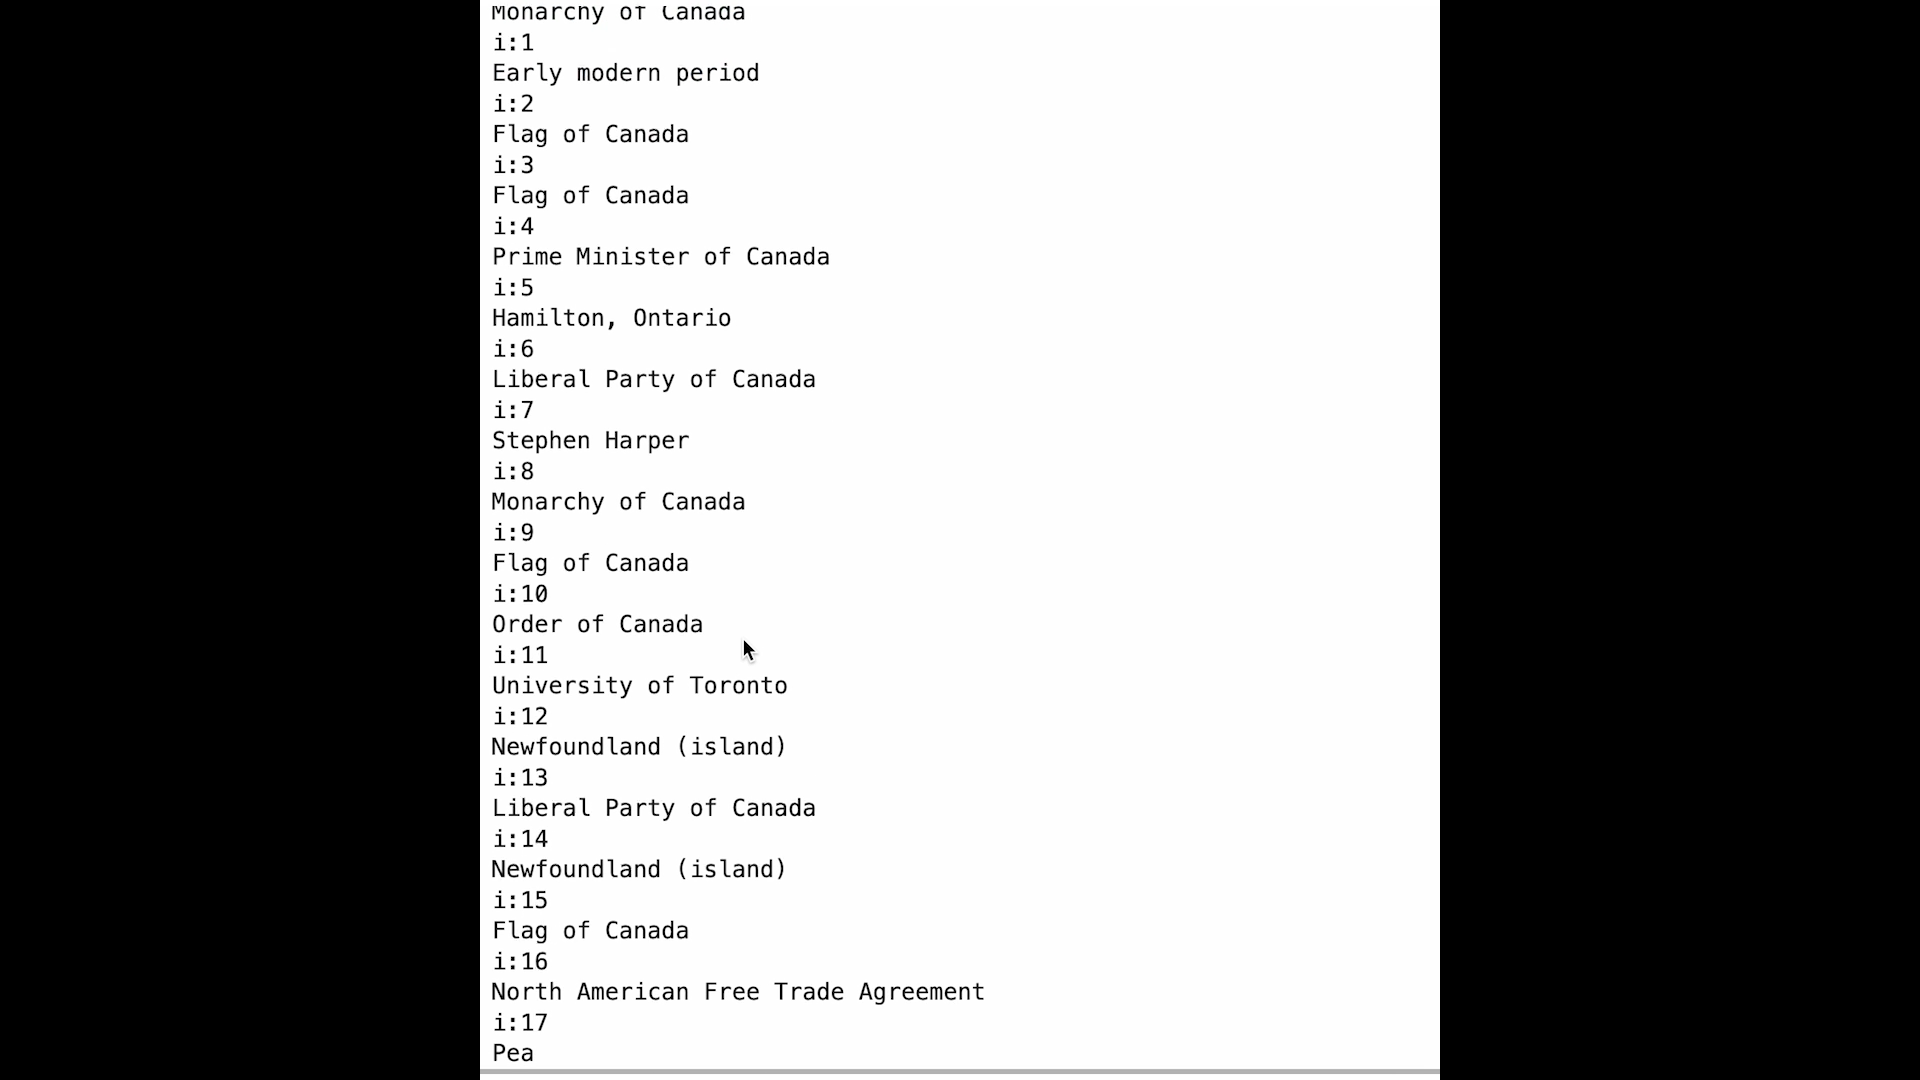

In [13]:
def rerank_responses(query, responses, num_responses=10):
    reranked_responses = co.rerank(
        model = 'rerank-english-v2.0',
        query = query,
        documents = responses,
        top_n = num_responses,
        )
    return reranked_responses

In [ ]:
texts = [result.get('text') for result in results]
reranked_text = rerank_responses(query_1, texts)

In [ ]:
for i, rerank_result in enumerate(reranked_text):
    print(f"i:{i}")
    print(f"{rerank_result}")
    print()

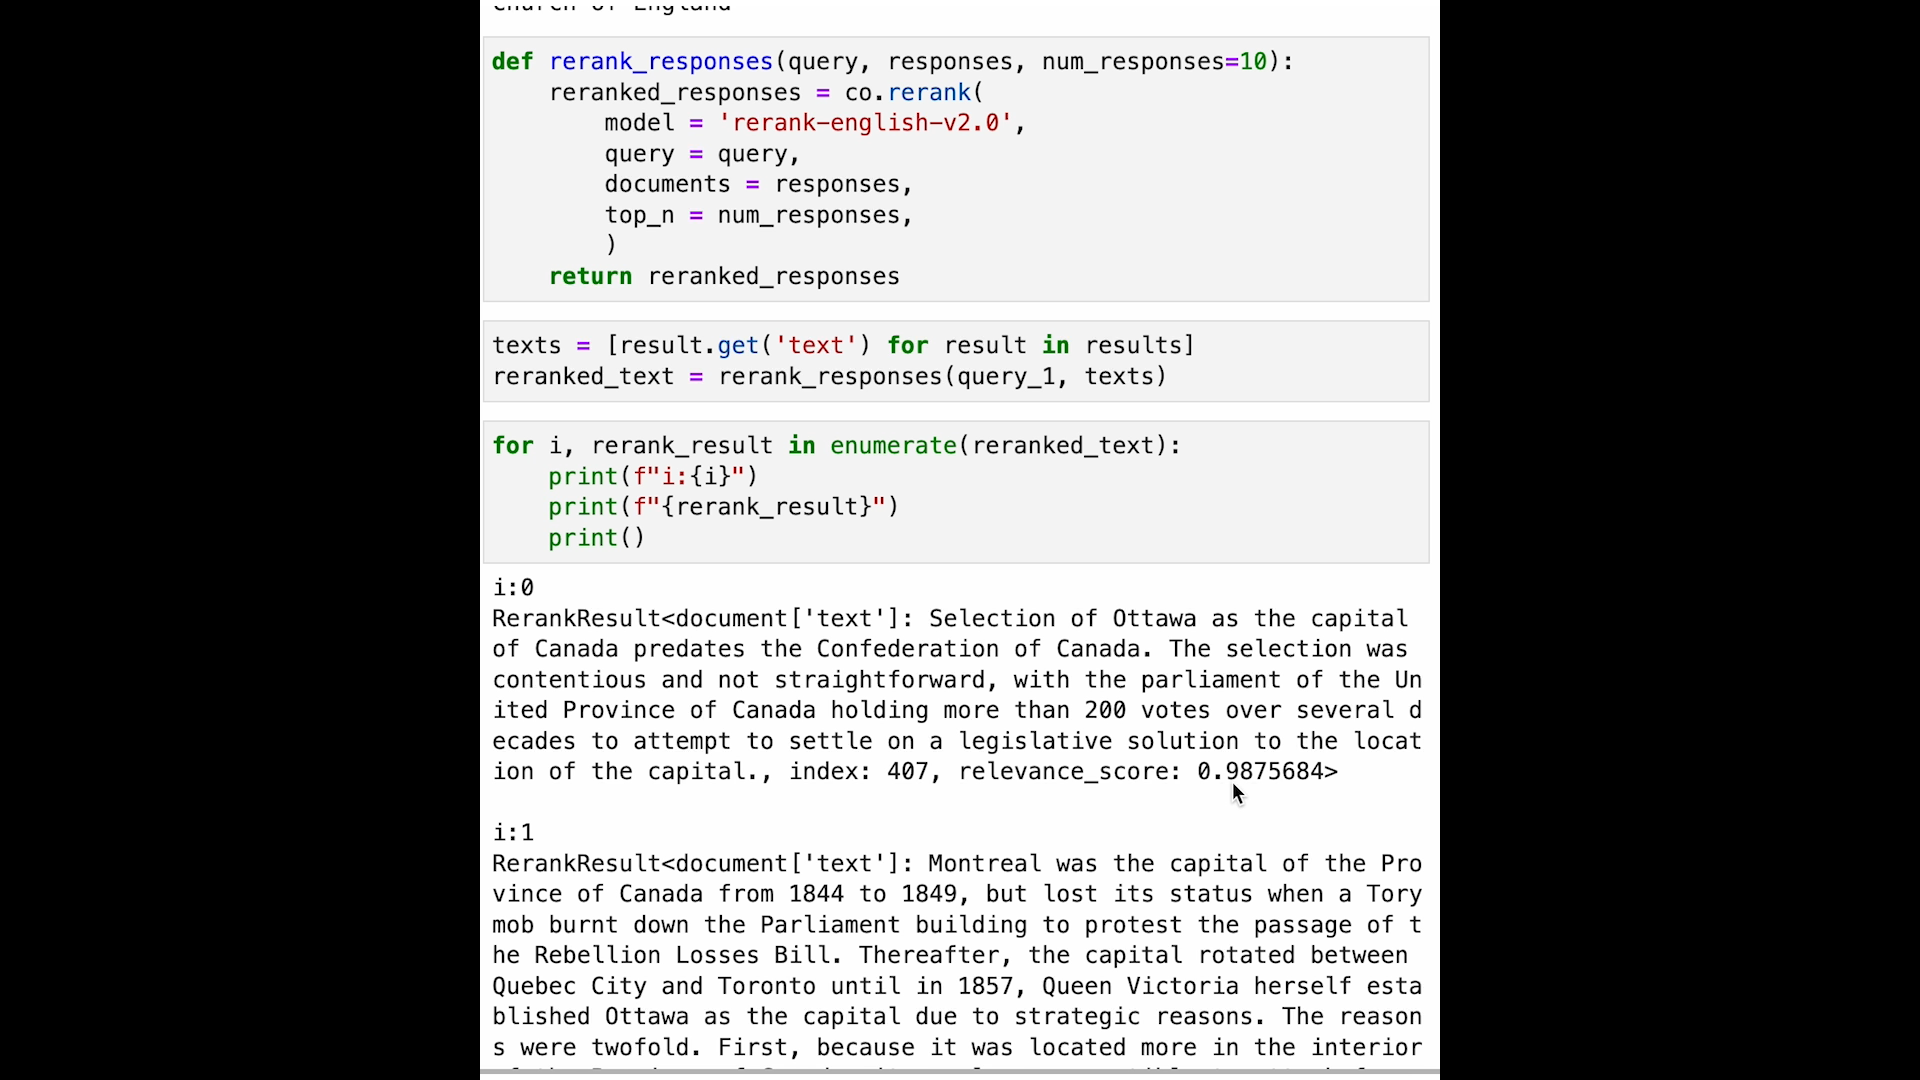

## Improving Dense Retrieval with ReRank

In [ ]:
query_2 = "Who is the tallest person in history?"
results = dense_retrieval(query_2,client)
for i, result in enumerate(results):
    print(f"i:{i}")
    print(result.get('title'))
    print(result.get('text'))
    print()


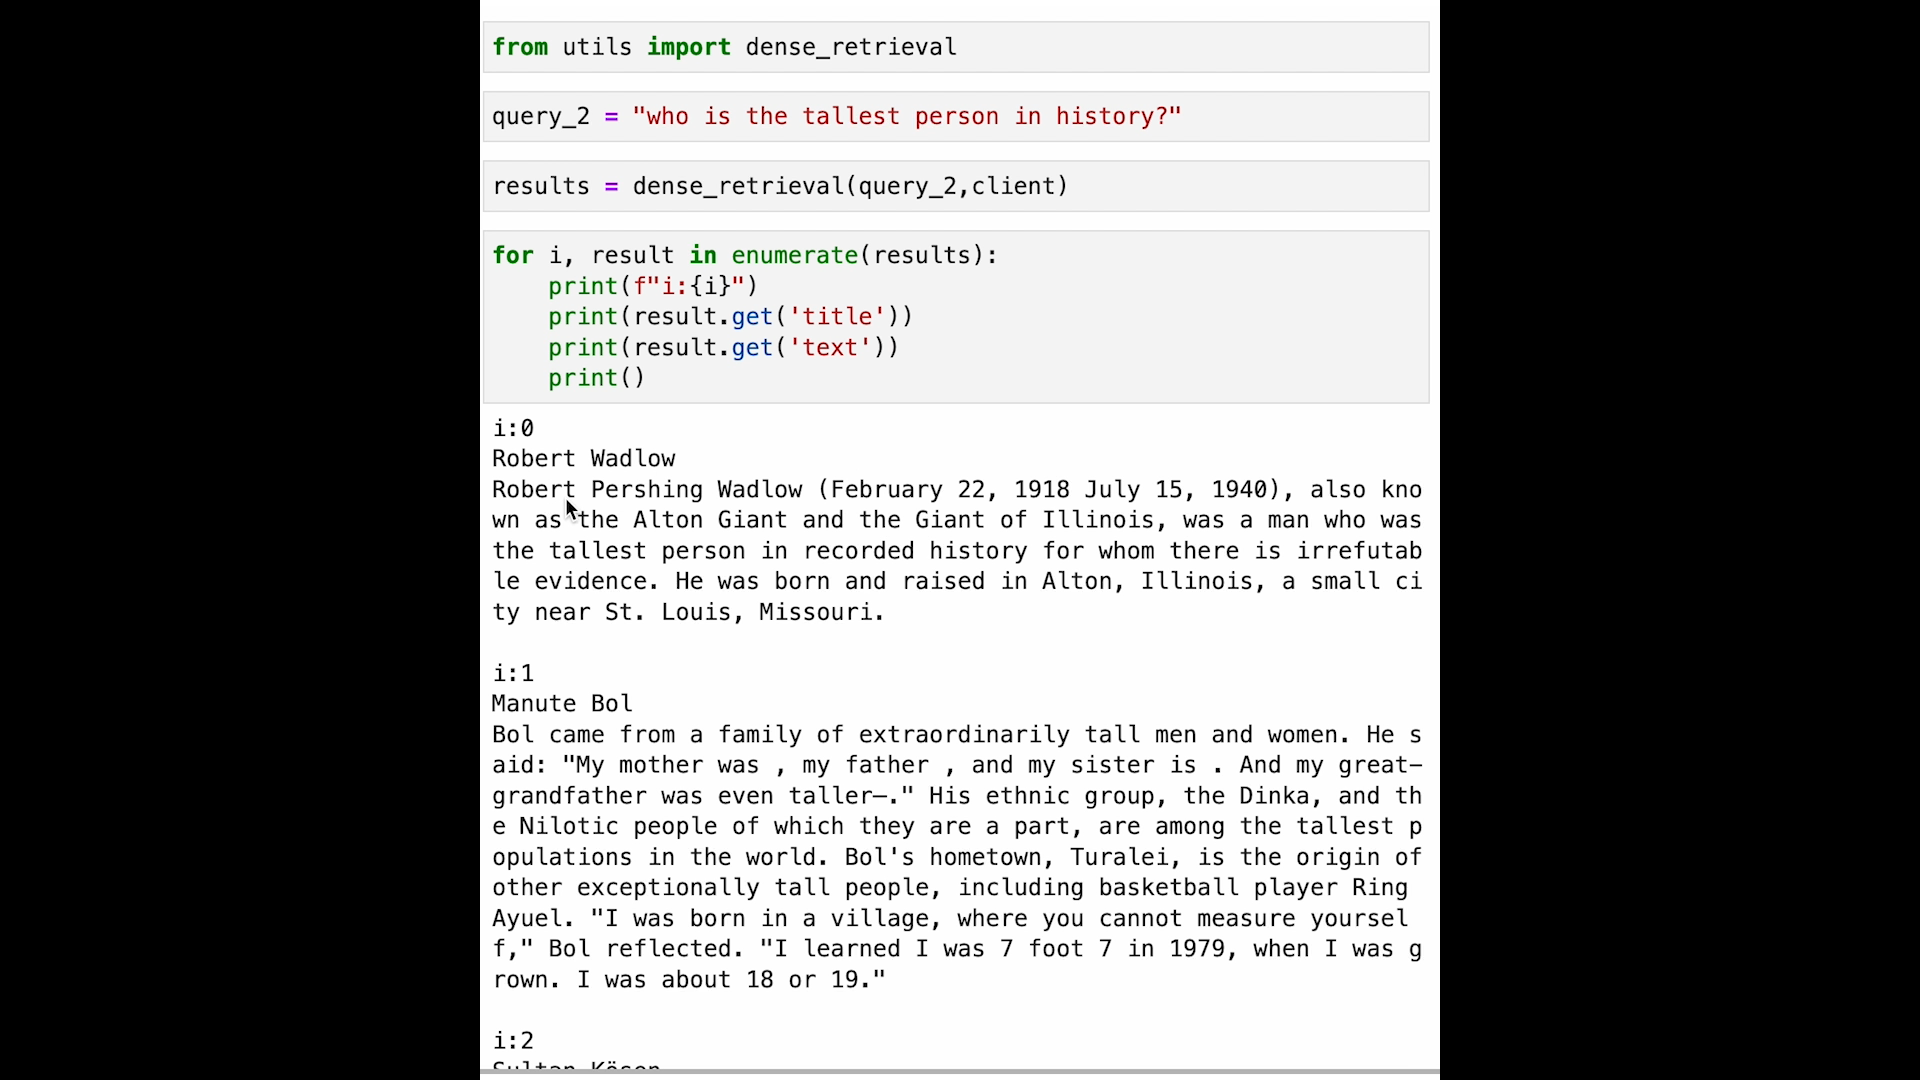

In [ ]:
texts = [result.get('text') for result in results]
reranked_text = rerank_responses(query_2, texts)

In [ ]:
for i, rerank_result in enumerate(reranked_text):
    print(f"i:{i}")
    print(f"{rerank_result}")
    print()

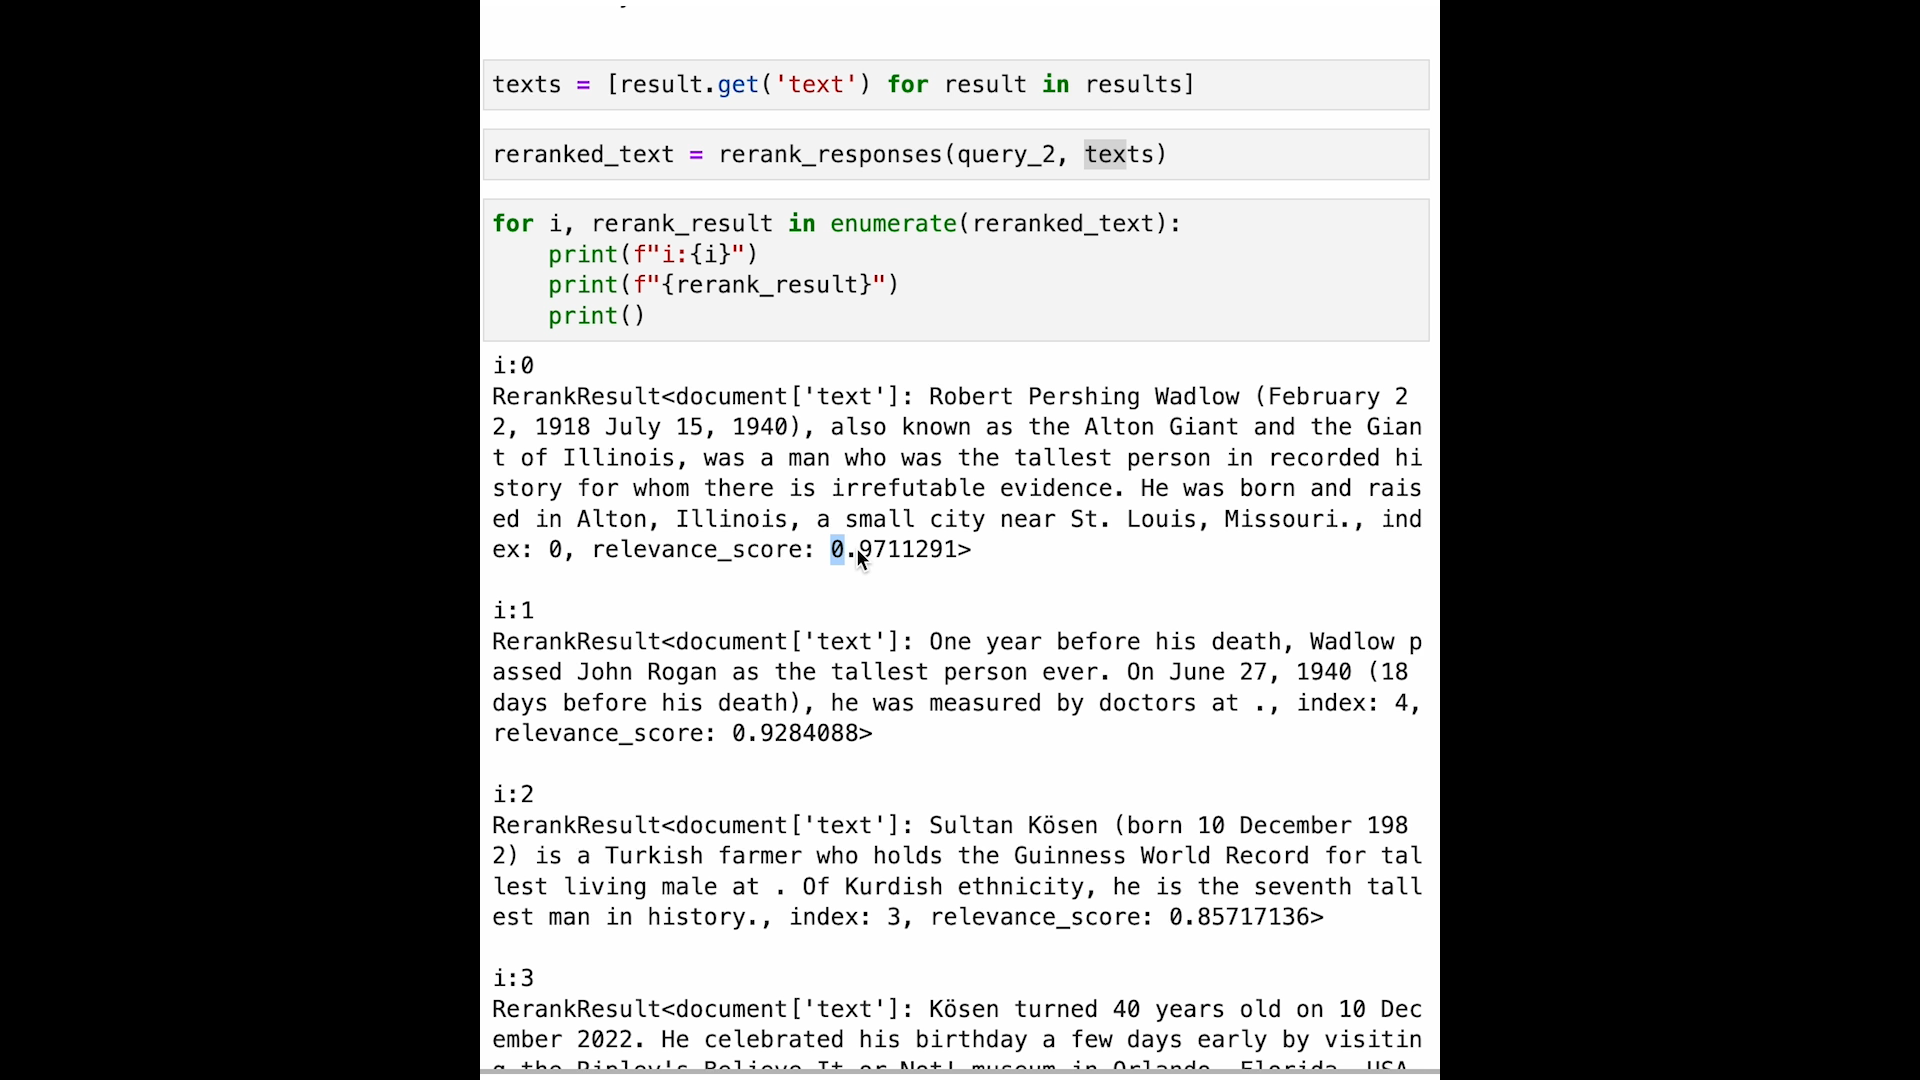

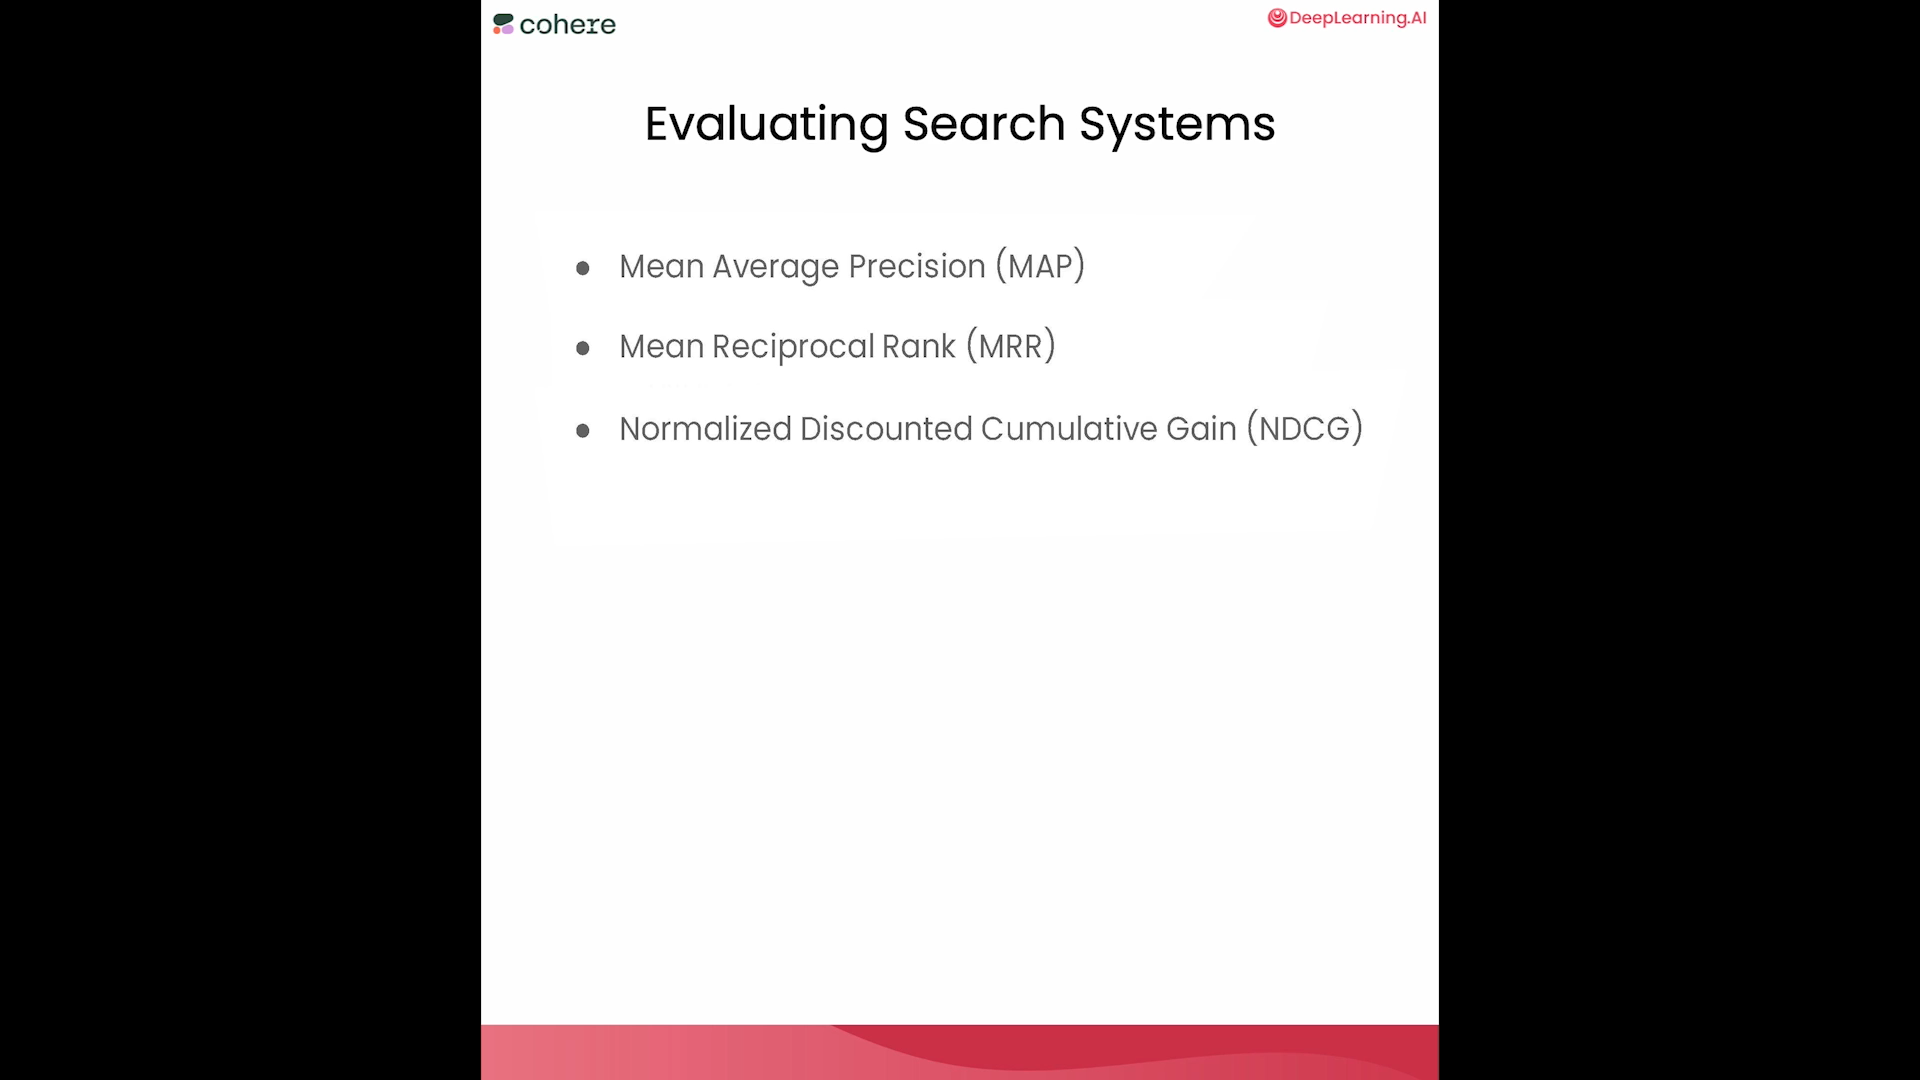